# Partition of Unity Networks (POUnets)

In this tutorial, we demonstrate how POUnets may be initialized and trained to reconstruct quantities of interest (QoIs).

In [1]:
from PCAfold import PartitionOfUnityNetwork, init_uniform_partitions
import numpy as np
import matplotlib.pyplot as plt

First, we create a two-dimensional manifold with vacant patches. This is shown in the first plot, colored by a dependent variable or QoI. We then ask to initialize partitions over a 5x2 grid. We find that only 8 of the 10 partitions are retained, as those initialized in the vacant spaces are discarded. We then visualize the locations of these partition centers, which exist in the normalized manifold space, along with the normalized data.


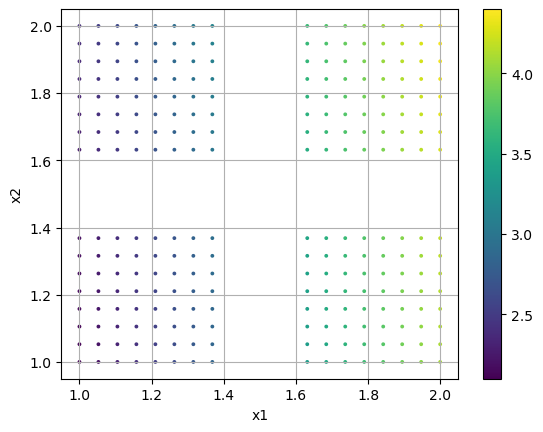

kept 8 partitions out of 10


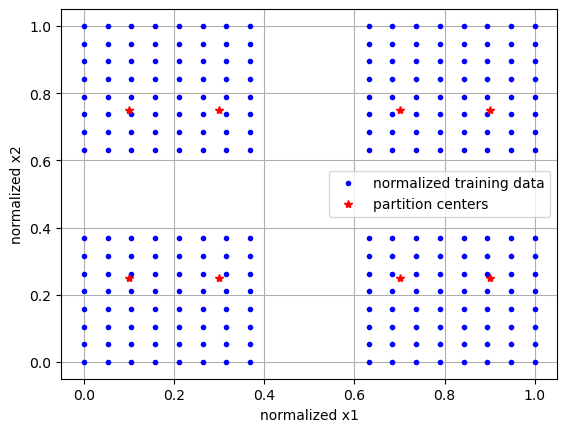

In [2]:
ivar1 = np.linspace(1,2,20)
ivar1 = ivar1[np.argwhere((ivar1<1.4)|(ivar1>1.6))[:,0]] # create hole
ivars = np.meshgrid(ivar1, ivar1) # make 2D
ivars = np.vstack([b.ravel() for b in ivars]).T # reshape (nobs x ndim)

dvar = 2.*ivars[:,0] + 0.1*ivars[:,1]**2

plt.scatter(ivars[:,0],ivars[:,1], s=3, c=dvar)
plt.colorbar()
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

init_data = init_uniform_partitions([5,2], ivars, verbose=True) # initialize partitions
ivars_cs = (ivars - init_data['ivar_center'])/init_data['ivar_scale'] # center/scale ivars

plt.plot(ivars_cs[:,0],ivars_cs[:,1], 'b.', label='normalized training data')
plt.plot(init_data['partition_centers'][:,0], init_data['partition_centers'][:,1], 'r*', label='partition centers')
plt.grid()
plt.xlabel('normalized x1')
plt.ylabel('normalized x2')
plt.legend()
plt.show()


We can now initialize a POUnet with a linear basis, build the graph with absolute training errors, and train for 1000 iterations.

There are also options, as outlined in the documentation, to set transformation parameters for training on a transformed dvar.

In [3]:
net = PartitionOfUnityNetwork(**init_data, 
                              basis_type='linear',
#                               transform_power=1.,
#                               transform_shift=0.,
#                               transform_sign_shift=0.
                             )
net.build_training_graph(ivars, dvar, error_type='abs')
net.train(1000, archive_rate=100, verbose=True)


------------------------------------------------------------
   iteration |   mean sqr |      % max  |    sum sqr
------------------------------------------------------------
         100 |   1.93e-06 |       0.22% |   4.93e-04
resetting best error
         200 |   1.75e-06 |       0.21% |   4.49e-04
resetting best error
         300 |   1.69e-06 |       0.20% |   4.33e-04
resetting best error
         400 |   1.66e-06 |       0.20% |   4.25e-04
resetting best error
         500 |   1.64e-06 |       0.20% |   4.21e-04
resetting best error
         600 |   1.05e-06 |       0.20% |   2.68e-04
resetting best error
         700 |   5.25e-07 |       0.21% |   1.34e-04
resetting best error
         800 |   2.07e-07 |       0.22% |   5.29e-05
resetting best error
         900 |   2.57e-10 |       0.01% |   6.58e-08
resetting best error
        1000 |   1.06e-10 |       0.01% |   2.72e-08
resetting best error


The learning rate (default 1e-3) and least squares l2 regularization (default 1e-10) can also be updated at any time.

In [4]:
net.update_lr(1.e-4)
net.update_l2reg(1.e-12)
net.train(200, archive_rate=100, verbose=True)


updating lr: 0.0001
updating l2reg: 1e-12
------------------------------------------------------------
   iteration |   mean sqr |      % max  |    sum sqr
------------------------------------------------------------
         100 |   1.01e-10 |       0.01% |   2.58e-08
resetting best error
         200 |   9.61e-11 |       0.01% |   2.46e-08
resetting best error


Here we visualize the error during training at every 100th iteration, which is the default archive rate.

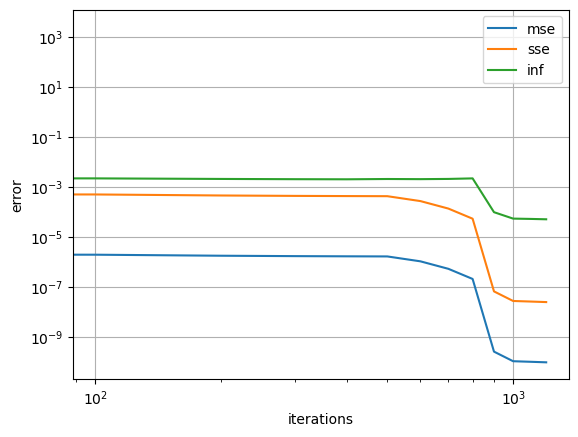

In [5]:
err_dict = net.training_archive

for k in ['mse', 'sse', 'inf']:
    plt.loglog(net.iterations,err_dict[k],'-', label=k)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()


We can evaluate the POUnet and its derivatives.

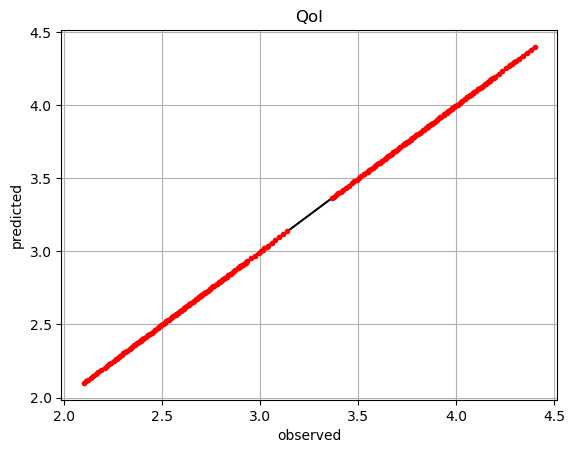

In [6]:
pred = net(ivars)

plt.plot(dvar,dvar,'k-')
plt.plot(dvar,pred,'r.')
plt.grid()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('QoI')
plt.show()


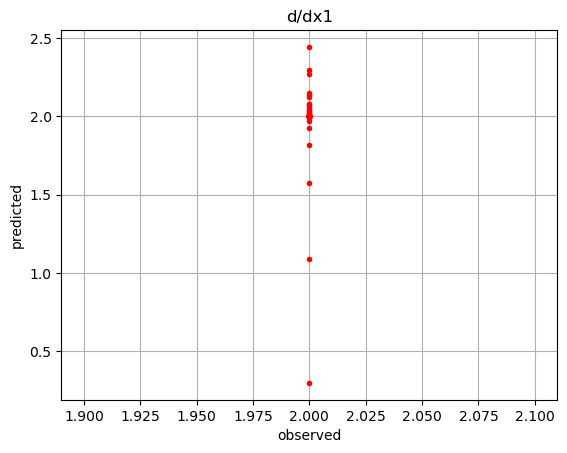

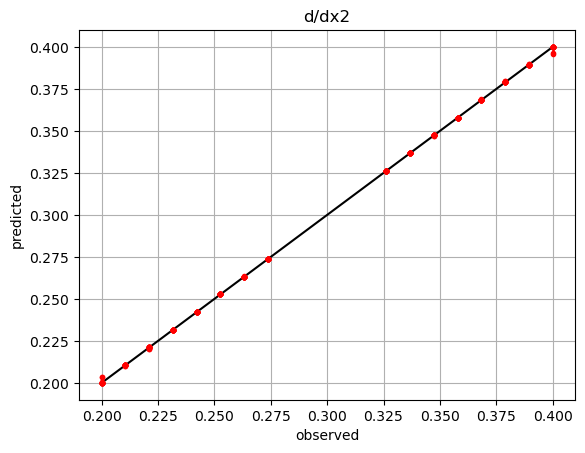

In [7]:
der = net.derivatives(ivars) # predicted

der1 = 2.*np.ones_like(dvar) # observed
der2 = 0.2*ivars[:,1] # observed

plt.plot(der1,der1,'k-')
plt.plot(der1,der[:,0],'r.')
plt.grid()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('d/dx1')
plt.show()

plt.plot(der2,der2,'k-')
plt.plot(der2,der[:,1],'r.')
plt.grid()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('d/dx2')
plt.show()



We can then save and load the POUnet parameters to/from file. The training history needs to be saved separately if desired.

In [8]:
# Save the POUnet to a file
net.write_data_to_file('filename.pkl')

# Load a POUnet from file
net2 = PartitionOfUnityNetwork.load_from_file('filename.pkl')

# Evaluate the loaded POUnet (without needing to build the graph)
pred2 = net2(ivars)


It is also possible to train a POUnet more after loading from file...

In [9]:
net2.build_training_graph(ivars, dvar, error_type='abs')
net2.train(1000, archive_rate=100, verbose=False)


Notice how the error history for the loaded POUnet only includes the recent training.

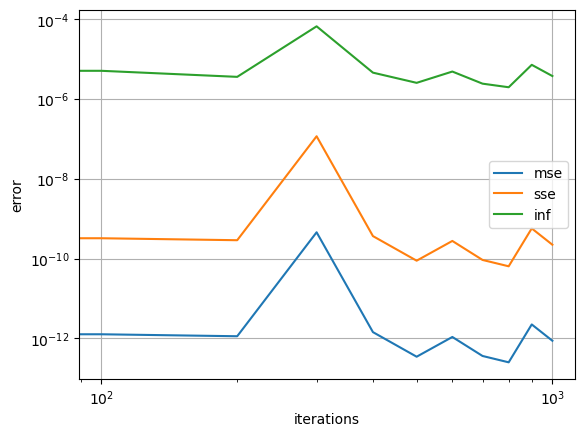

In [10]:
err_dict = net2.training_archive

for k in ['mse', 'sse', 'inf']:
    plt.loglog(net2.iterations,err_dict[k],'-', label=k)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()


More training may be beneficial if new training data, perhaps with more resolution, become available...

In [11]:
ivars2 = np.meshgrid(np.linspace(1,2,20), np.linspace(1,2,20))
ivars2 = np.vstack([b.ravel() for b in ivars2]).T

dvar2 = 2.*ivars2[:,0] + 0.1*ivars2[:,1]**2

net2.build_training_graph(ivars2, dvar2, error_type='abs')
net2.train(1000, archive_rate=100, verbose=False)


If we have a different QoI that we want to use the same partitions for, we may also create a new POUnet from trained parameters and redo the least squares regression to update the basis coefficients appropriately...

performing least-squares solve


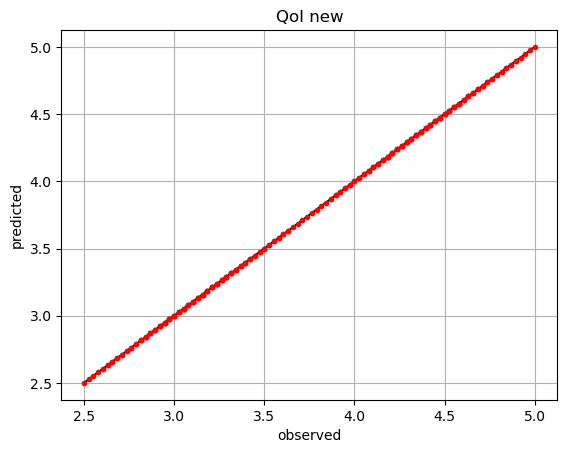

In [12]:
dvar_new = ivars[:,0]*2 + 0.5*ivars[:,1]

net_new = PartitionOfUnityNetwork.load_from_file('filename.pkl')

net_new.build_training_graph(ivars, dvar_new)
net_new.lstsq()

pred_new = net_new(ivars)

plt.plot(dvar_new,dvar_new,'k-')
plt.plot(dvar_new,pred_new,'r.')
plt.grid()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('QoI new')
plt.show()


There is also flexibility in adding/removing partitions or changing the basis degree, but the parameters must be appropriately resized for such changes.

Below, we remove the 4th partition from the originally trained POUnet. Partition parameters are shaped as n_partition x n_dim while the basis coefficients can easily be reshaped into n_basis x n_partition as shown below. Since we had a linear basis, the number of terms in each partition's basis function is 3: a constant, linear in x1, and linear in x2.


In [13]:
pou_data = PartitionOfUnityNetwork.load_data_from_file('filename.pkl')

i_partition_remove = 3 # index to remove the 4th partition

old_coeffs = pou_data['basis_coeffs'].reshape(3,pou_data['partition_centers'].shape[0]) # reshape basis coeffs into n_basis x n_partition

pou_data['partition_centers'] = np.delete(pou_data['partition_centers'], i_partition_remove, axis=0) # remove the 4th row
pou_data['partition_shapes'] = np.delete(pou_data['partition_shapes'], i_partition_remove, axis=0) # remove the 4th row
pou_data['basis_coeffs'] = np.expand_dims(np.delete(old_coeffs, i_partition_remove, axis=1).ravel(), axis=0) # remove the 4th column


We then simply initialize a new POUnet with the modified data and continue training.

In [14]:
net_modified = PartitionOfUnityNetwork(**pou_data)
net_modified.build_training_graph(ivars, dvar, error_type='abs')
net_modified.train(1000, archive_rate=100, verbose=False)


We could also change the basis type and modify the basis coefficient size accordingly.
Below, we change the basis from linear to quadratic, which adds 3 additional terms: x1^2, x2^2, and x1x2.
We initialize these coefficients to zero and perform the least squares to update them appropriately.
Further training could be performed if desired.

In [15]:
pou_data = PartitionOfUnityNetwork.load_data_from_file('filename.pkl')

old_coeffs = pou_data['basis_coeffs'].reshape(3,pou_data['partition_centers'].shape[0]) # reshape basis coeffs into n_basis x n_partition
old_coeffs = np.vstack((old_coeffs, np.zeros((3,old_coeffs.shape[1])))) # add basis terms for x1^2, x2^2, and x1x2
pou_data['basis_coeffs'] = np.expand_dims(old_coeffs.ravel(), axis=0)
pou_data['basis_type'] = 'quadratic'

net_modified = PartitionOfUnityNetwork(**pou_data)
net_modified.build_training_graph(ivars, dvar, error_type='abs')
net_modified.lstsq()


performing least-squares solve
